Imports needen only in Colab

In [0]:
#!pip install -q tensorflow-gpu==2.0.0-beta0
#!git clone https://gitlab.com/0darnox0/snr.git
import os
# from google.colab import drive
# drive.mount('/content/drive/')
# try:
os.chdir("/content/snr")
# except FileNotFoundError:
#     pass

All other imports

In [0]:
import tensorflow as tf
from tensorflow import keras

import tensorflow as tf
import os
os.chdir("/content/snr") 


import numpy as np

from definitions import *
from preprocessing import load_datasets, time_footprint, load_labels_datasets

# Load datasets

In [4]:
train_ds, test_ds, val_ds = load_datasets()

W0611 00:52:28.432027 140498777405312 deprecation.py:323] From /content/snr/preprocessing.py:56: shuffle_and_repeat (from tensorflow.python.data.experimental.ops.shuffle_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.


# Create model

In [0]:
ALPHA = 1.0  # controls the width of the network
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape = IMG_SHAPE,
                                               include_top = False, 
                                               alpha       = ALPHA,
                                               weights     = 'imagenet')

Now we want to train all layers of **MobileNetV2** model.

In [6]:
base_model.summary()

Model: "mobilenetv2_1.00_192"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 193, 193, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 96, 96, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 96, 96, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [0]:
base_model.trainable = True

In [0]:
model = tf.keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(NUMBER_OF_LABELS, activation='softmax')
])

In [0]:
base_learning_rate = 2.5e-5
model.compile(optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate), 
              loss      = 'sparse_categorical_crossentropy', 
              metrics   = ['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 106)               135786    
Total params: 2,393,770
Trainable params: 2,359,658
Non-trainable params: 34,112
_________________________________________________________________


# Test model (3a)

In [11]:
#additional packages added
time_fp = time_footprint()
from __future__ import absolute_import, division, print_function, unicode_literals
import math

#checkpoint delcaration
weights_dir = '/content/snr/models/task_3_a_2019-06-09_23-49-47'
latest = tf.train.latest_checkpoint(weights_dir)

#loading model
model.load_weights(latest)
model.summary()

#fetching data
train_ds, test_ds, val_ds = load_datasets()
train_labels_ds, test_labels_ds, val_labels_ds = load_labels_datasets()
tf.executing_eagerly()

#real labels for test dataset
real_test_ds_lables = [x.numpy() for x in test_labels_ds]

#computing accuracy
loss, acc = model.evaluate(test_ds, steps = 106)


#preparing predictions
predictions = model.predict(test_ds, verbose=1, steps = None)


n = 106 # number of classes
cmc_rate= [0 for i in range(0,106)] 

#algorithm for computing rate for each topN classification
#step no. 1: Count rate for top1
#step no. 2: Count deltas for each next topN classifiaction
i = 0
for x in predictions:
    temp = []
    temp = x.tolist()

    for a in range(0,n):
      maxIndex = temp.index(max(temp))
      temp[maxIndex] = 0
      if real_test_ds_lables[i] == maxIndex:
        cmc_rate[a] += 1

    i+=1
      
#counting relative value of topN error
cmc_rate = [i/len(predictions) for i in cmc_rate]
real_crc_rate = [0 for i in range(0,106)]
real_crc_rate[0]  = cmc_rate[0]

#summing deltas in order to count topN rate for N>1 
for i in range(1,106):
    real_crc_rate[i] = real_crc_rate[i-1] + cmc_rate[i]





Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 106)               135786    
Total params: 2,393,770
Trainable params: 2,359,658
Non-trainable params: 34,112
_________________________________________________________________
106/106 [==============================] - 34s 318ms/step - loss: 0.7283 - accuracy: 0.8196
    120/Unknown - 36s 300ms/step

#Dispaly evaluation (3a)



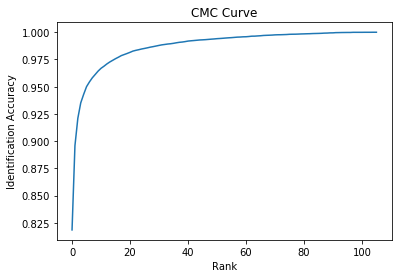


Restored model, accuracy: 81.96%

TOP1 error rate: 18.15%

TOP5 error rate:  5.71%


In [12]:
print("")
import matplotlib.pyplot as plt
plt.plot(real_crc_rate)
plt.ylabel('Identification Accuracy')
plt.xlabel('Rank')
plt.title('CMC Curve')
plt.show()

print("")
print("Restored model, accuracy: {:5.2f}%".format(100*acc))
print("")
print("TOP1 error rate: {:5.2f}%".format(100*(1.0 - real_crc_rate[0])))
print("")
print("TOP5 error rate: {:5.2f}%".format(100*(1.0 - real_crc_rate[4])))

## Create simpler model

In [0]:
simpler_base_model = tf.keras.applications.MobileNetV2(input_shape = IMG_SHAPE,
                                                       include_top = False, 
                                                       alpha       = ALPHA,
                                                       weights     = 'imagenet')

Remove block_16 layers from base model

In [0]:
last_layer_old = simpler_base_model.get_layer('block_15_project_BN').output
x = keras.layers.Conv2D(**simpler_base_model.get_layer('Conv_1').get_config())(last_layer_old)
x = keras.layers.BatchNormalization(**simpler_base_model.get_layer('Conv_1_bn').get_config())(x)
last_layer_new = keras.layers.ReLU(**simpler_base_model.get_layer('out_relu').get_config())(x)

In [0]:
simpler_base_model = tf.keras.Model(inputs = simpler_base_model.layers[0].input, outputs = last_layer_new, name='Simpler')

In [16]:
simpler_base_model.summary()

Model: "Simpler"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 193, 193, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 96, 96, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 96, 96, 32)   128         Conv1[0][0]                      
____________________________________________________________________________________________

In [0]:
simpler_base_model.trainable = True

In [0]:
simpler_model = tf.keras.Sequential([
    simpler_base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(NUMBER_OF_LABELS, activation='softmax')
])

In [0]:
base_learning_rate = 2.5e-5
simpler_model.compile(optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate), 
                      loss      = 'sparse_categorical_crossentropy', 
                      metrics   = ['accuracy'])

In [20]:
simpler_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Simpler (Model)              (None, 6, 6, 1280)        1574784   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 106)               135786    
Total params: 1,710,570
Trainable params: 1,680,938
Non-trainable params: 29,632
_________________________________________________________________


# Test simpler model (3b)

In [21]:
#additional packages added
time_fp = time_footprint()
from __future__ import absolute_import, division, print_function, unicode_literals
import math

#checkpoint delcaration
weights_dir = '/content/snr/models/task_3_b_2019-06-09_23-51-11'
latest = tf.train.latest_checkpoint(weights_dir)

#loading model
simpler_model.load_weights(latest)
simpler_model.summary()

#fetching data
train_ds, test_ds, val_ds = load_datasets()
train_labels_ds, test_labels_ds, val_labels_ds = load_labels_datasets()
tf.executing_eagerly()

#real labels for test dataset
real_test_ds_lables = [x.numpy() for x in test_labels_ds]

#computing accuracy
loss2, acc2 = simpler_model.evaluate(test_ds, steps = 106)


#preparing predictions
predictions = simpler_model.predict(test_ds, verbose=1, steps = None)


n = 106 # number of classes
cmc_rate= [0 for i in range(0,106)] 

#algorithm for computing rate for each topN classification
#step no. 1: Count rate for top1
#step no. 2: Count deltas for each next topN classifiaction
i = 0
for x in predictions:
    temp = []
    temp = x.tolist()

    for a in range(0,n):
      maxIndex = temp.index(max(temp))
      temp[maxIndex] = 0
      if real_test_ds_lables[i] == maxIndex:
        cmc_rate[a] += 1

    i+=1
      
#counting relative value of topN error
cmc_rate = [i/len(predictions) for i in cmc_rate]
real_crc_rate2 = [0 for i in range(0,106)]
real_crc_rate2[0]  = cmc_rate[0]

#summing deltas in order to count topN rate for N>1 
for i in range(1,106):
    real_crc_rate2[i] = real_crc_rate2[i-1] + cmc_rate[i]

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Simpler (Model)              (None, 6, 6, 1280)        1574784   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 106)               135786    
Total params: 1,710,570
Trainable params: 1,680,938
Non-trainable params: 29,632
_________________________________________________________________
106/106 [==============================] - 27s 259ms/step - loss: 0.6059 - accuracy: 0.8501
    120/Unknown - 30s 250ms/step

#Display evaluation (3b)

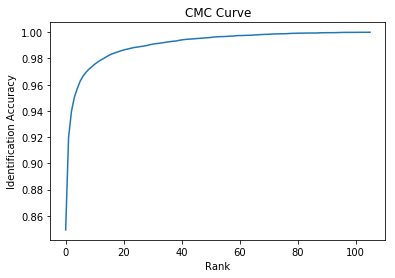


Restored model, accuracy: 85.01%

TOP1 error rate: 15.08%

TOP5 error rate:  4.30%


In [22]:
print("")
import matplotlib.pyplot as plt
plt.plot(real_crc_rate2)
plt.ylabel('Identification Accuracy')
plt.xlabel('Rank')
plt.title('CMC Curve')
plt.show()

print("")
print("Restored model, accuracy: {:5.2f}%".format(100*acc2))
print("")
print("TOP1 error rate: {:5.2f}%".format(100*(1.0 - real_crc_rate2[0])))
print("")
print("TOP5 error rate: {:5.2f}%".format(100*(1.0 - real_crc_rate2[4])))

#Comparison of models


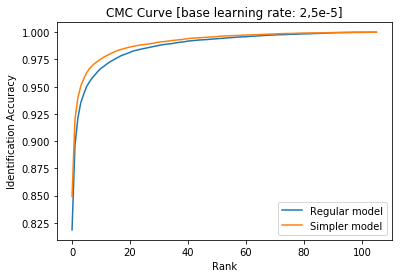

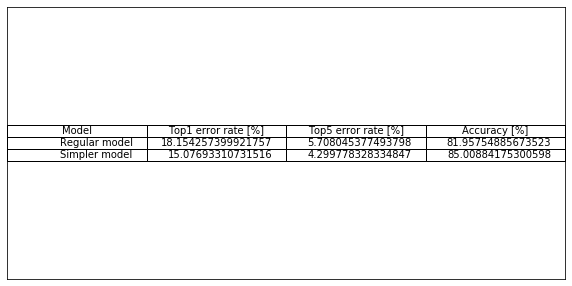

In [23]:
plt.plot(real_crc_rate, label='Regular model')
plt.plot(real_crc_rate2, label='Simpler model')
plt.legend(loc='best')
plt.ylabel('Identification Accuracy')
plt.xlabel('Rank')
plt.title('CMC Curve [base learning rate: 2,5e-5]')
plt.show()



fig=plt.figure(figsize=[10,5])

ax = fig.add_subplot(111)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
colLabels=("Model", "Top1 error rate [%]", "Top5 error rate [%]", "Accuracy [%]")
the_table = ax.table(cellText=[
    ["Regular model",100*(1.0 - real_crc_rate[0]),100*(1.0 - real_crc_rate[4]), acc*100],
    ["Simpler model",100*(1.0 - real_crc_rate2[0]),100*(1.0 - real_crc_rate2[4]), acc2*100]],
          colLabels=colLabels,
          loc='center')


